# K-FCA Implementation from Handwritten Example

This notebook implements K-Formal Concept Analysis based on the handwritten calculations.

In [1]:
import numpy as np
import pandas as pd
from typing import Set, Tuple, List
import matplotlib.pyplot as plt
import networkx as nx

## Step 1: Define the Context

Based on the handwritten notes, we have a formal context with objects and attributes.

In [2]:
# Define the formal context from the handwritten example
# Objects (rows) and Attributes (columns)
objects = ['1', '2', '3', '4', '5']
attributes = ['a', 'b', 'c', 'd']

# Create the incidence matrix from the handwritten example
# Using fuzzy/K-values instead of binary
context = np.array([
    [0.8, 0.6, 0.0, 0.0],  # Object 1
    [0.9, 0.0, 0.7, 0.0],  # Object 2
    [0.0, 0.8, 0.0, 0.6],  # Object 3
    [0.0, 0.0, 0.9, 0.7],  # Object 4
    [0.5, 0.0, 0.0, 0.8]   # Object 5
])

# Create DataFrame for better visualization
df = pd.DataFrame(context, index=objects, columns=attributes)
print("Formal Context (K-values):")
print(df)

Formal Context (K-values):
     a    b    c    d
1  0.8  0.6  0.0  0.0
2  0.9  0.0  0.7  0.0
3  0.0  0.8  0.0  0.6
4  0.0  0.0  0.9  0.7
5  0.5  0.0  0.0  0.8


## Step 2: Define K-FCA Operations

Implement the derivation operators for K-FCA.

In [3]:
def extent_operator(attributes_set: Set[str], k: float) -> Set[str]:
    """
    Given a set of attributes, find all objects that have ALL these attributes
    with at least value k (using minimum t-norm).
    """
    if not attributes_set:
        return set(objects)
    
    extent = set()
    attr_indices = [attributes.index(a) for a in attributes_set]
    
    for i, obj in enumerate(objects):
        # Get minimum value across all selected attributes (t-norm)
        min_val = min(context[i, attr_idx] for attr_idx in attr_indices)
        if min_val >= k:
            extent.add(obj)
    
    return extent


def intent_operator(objects_set: Set[str], k: float) -> Set[str]:
    """
    Given a set of objects, find all attributes that ALL these objects have
    with at least value k.
    """
    if not objects_set:
        return set(attributes)
    
    intent = set()
    obj_indices = [objects.index(o) for o in objects_set]
    
    for j, attr in enumerate(attributes):
        # Get minimum value across all selected objects
        min_val = min(context[obj_idx, j] for obj_idx in obj_indices)
        if min_val >= k:
            intent.add(attr)
    
    return intent


def closure(attributes_set: Set[str], k: float) -> Set[str]:
    """
    Apply both operators: A -> A' -> A''
    This gives the closure of the attribute set.
    """
    extent = extent_operator(attributes_set, k)
    return intent_operator(extent, k)


def is_closed(attributes_set: Set[str], k: float) -> bool:
    """
    Check if an attribute set is closed (i.e., A'' = A).
    """
    return closure(attributes_set, k) == attributes_set

## Step 3: Find All K-Concepts

A K-concept is a pair (extent, intent) where:
- extent' = intent
- intent' = extent

In [4]:
def find_all_concepts(k: float) -> List[Tuple[Set[str], Set[str]]]:
    """
    Find all formal concepts at level k.
    """
    concepts = []
    
    # Generate all possible attribute subsets
    from itertools import combinations
    
    all_subsets = []
    for i in range(len(attributes) + 1):
        for subset in combinations(attributes, i):
            all_subsets.append(set(subset))
    
    # For each subset, check if it's closed
    closed_sets = set()
    for attr_set in all_subsets:
        closed = closure(attr_set, k)
        closed_sets.add(frozenset(closed))
    
    # Build concepts from closed sets
    for closed_intent in closed_sets:
        intent = set(closed_intent)
        extent = extent_operator(intent, k)
        concepts.append((extent, intent))
    
    return concepts


# Test with k = 0.5 (as shown in handwritten notes)
k_value = 0.5
concepts = find_all_concepts(k_value)

print(f"\nK-Concepts for k = {k_value}:")
print(f"Total number of concepts: {len(concepts)}\n")

for i, (extent, intent) in enumerate(concepts, 1):
    print(f"Concept {i}:")
    print(f"  Extent: {sorted(extent) if extent else '∅'}")
    print(f"  Intent: {sorted(intent) if intent else '∅'}")
    print()


K-Concepts for k = 0.5:
Total number of concepts: 11

Concept 1:
  Extent: ['3', '4', '5']
  Intent: ['d']

Concept 2:
  Extent: ['2', '4']
  Intent: ['c']

Concept 3:
  Extent: ['3']
  Intent: ['b', 'd']

Concept 4:
  Extent: ['1']
  Intent: ['a', 'b']

Concept 5:
  Extent: ['5']
  Intent: ['a', 'd']

Concept 6:
  Extent: ∅
  Intent: ['a', 'b', 'c', 'd']

Concept 7:
  Extent: ['2']
  Intent: ['a', 'c']

Concept 8:
  Extent: ['1', '2', '3', '4', '5']
  Intent: ∅

Concept 9:
  Extent: ['1', '2', '5']
  Intent: ['a']

Concept 10:
  Extent: ['1', '3']
  Intent: ['b']

Concept 11:
  Extent: ['4']
  Intent: ['c', 'd']



## Step 4: Build the Concept Lattice

Order concepts by extent inclusion (or equivalently, intent reverse inclusion).

In [5]:
def build_lattice(concepts: List[Tuple[Set[str], Set[str]]]) -> nx.DiGraph:
    """
    Build the Hasse diagram of the concept lattice.
    Concept (A1, B1) <= (A2, B2) iff A1 ⊆ A2 (equivalently B2 ⊆ B1).
    """
    G = nx.DiGraph()
    
    # Add all concepts as nodes
    for i, (extent, intent) in enumerate(concepts):
        extent_str = '{' + ', '.join(sorted(extent)) + '}' if extent else '∅'
        intent_str = '{' + ', '.join(sorted(intent)) + '}' if intent else '∅'
        label = f"{extent_str}\n{intent_str}"
        G.add_node(i, extent=extent, intent=intent, label=label)
    
    # Add edges for direct subconcept relationships
    for i, (extent1, intent1) in enumerate(concepts):
        for j, (extent2, intent2) in enumerate(concepts):
            if i != j and extent1.issubset(extent2) and extent1 != extent2:
                # Check if it's a direct subconcept (no intermediate concept)
                is_direct = True
                for k, (extent3, intent3) in enumerate(concepts):
                    if k != i and k != j:
                        if extent1.issubset(extent3) and extent3.issubset(extent2):
                            if extent1 != extent3 and extent3 != extent2:
                                is_direct = False
                                break
                
                if is_direct:
                    G.add_edge(i, j)
    
    return G


# Build the lattice
lattice = build_lattice(concepts)
print(f"Lattice has {lattice.number_of_nodes()} nodes and {lattice.number_of_edges()} edges.")

Lattice has 11 nodes and 19 edges.


## Step 5: Visualize the Concept Lattice

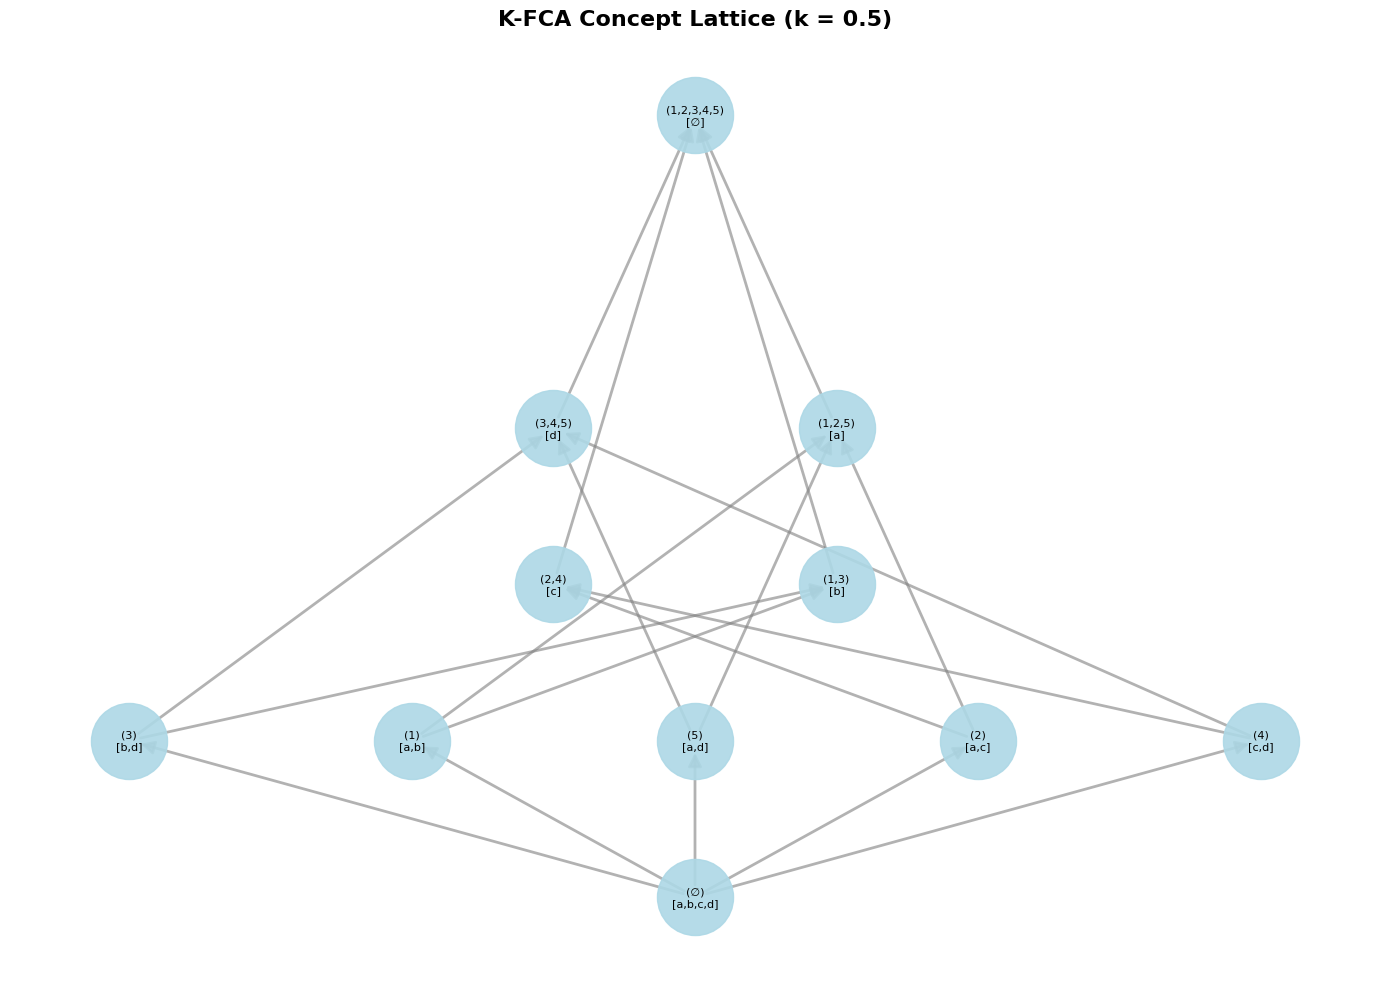

In [6]:
def visualize_lattice(G: nx.DiGraph):
    """
    Visualize the concept lattice.
    """
    plt.figure(figsize=(14, 10))
    
    # Use hierarchical layout
    pos = nx.spring_layout(G, k=2, iterations=50)
    
    # Try to create a more hierarchical layout
    # Group by extent size for better visualization
    levels = {}
    for node in G.nodes():
        extent_size = len(G.nodes[node]['extent'])
        if extent_size not in levels:
            levels[extent_size] = []
        levels[extent_size].append(node)
    
    pos = {}
    for level, nodes in sorted(levels.items()):
        for i, node in enumerate(nodes):
            x = (i - len(nodes)/2) * 2
            y = level * 2
            pos[node] = (x, y)
    
    # Draw the graph
    nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True, 
                          arrowsize=20, width=2, alpha=0.6)
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', 
                          node_size=3000, alpha=0.9)
    
    # Draw simplified labels
    labels = {}
    for node in G.nodes():
        extent = G.nodes[node]['extent']
        intent = G.nodes[node]['intent']
        extent_str = ','.join(sorted(extent)) if extent else '∅'
        intent_str = ','.join(sorted(intent)) if intent else '∅'
        labels[node] = f"({extent_str})\n[{intent_str}]"
    
    nx.draw_networkx_labels(G, pos, labels, font_size=8)
    
    plt.title(f"K-FCA Concept Lattice (k = {k_value})", fontsize=16, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()


visualize_lattice(lattice)

## Step 6: Calculate Concept Properties

Analyze the lattice structure.

In [7]:
# Find top and bottom concepts
top_concepts = [n for n in lattice.nodes() if lattice.out_degree(n) == 0]
bottom_concepts = [n for n in lattice.nodes() if lattice.in_degree(n) == 0]

print("Lattice Structure Analysis:")
print(f"\nTop concept(s):")
for node in top_concepts:
    extent = lattice.nodes[node]['extent']
    intent = lattice.nodes[node]['intent']
    print(f"  Extent: {sorted(extent) if extent else '∅'}")
    print(f"  Intent: {sorted(intent) if intent else '∅'}")

print(f"\nBottom concept(s):")
for node in bottom_concepts:
    extent = lattice.nodes[node]['extent']
    intent = lattice.nodes[node]['intent']
    print(f"  Extent: {sorted(extent) if extent else '∅'}")
    print(f"  Intent: {sorted(intent) if intent else '∅'}")

print(f"\nLattice statistics:")
print(f"  Number of concepts: {len(concepts)}")
print(f"  Number of edges: {lattice.number_of_edges()}")
print(f"  Height: {nx.dag_longest_path_length(lattice) if nx.is_directed_acyclic_graph(lattice) else 'N/A'}")

Lattice Structure Analysis:

Top concept(s):
  Extent: ['1', '2', '3', '4', '5']
  Intent: ∅

Bottom concept(s):
  Extent: ∅
  Intent: ['a', 'b', 'c', 'd']

Lattice statistics:
  Number of concepts: 11
  Number of edges: 19
  Height: 3


## Step 7: Simpler Approach - Object and Attribute Concepts Only

Instead of checking ALL attribute combinations, we can find concepts by starting only from:
1. Individual objects
2. Individual attributes  
3. Empty set (top and bottom concepts)

This is faster and often sufficient!

In [8]:
def find_basic_concepts(k: float) -> List[Tuple[Set[str], Set[str]]]:
    """
    Find concepts by starting only from individual objects and attributes.
    This is the simpler approach matching the handwritten calculations.
    """
    concepts = []
    seen = set()
    
    # 1. Top concept: Start from empty attribute set
    top_extent = extent_operator(set(), k)
    top_intent = intent_operator(top_extent, k)
    concepts.append((top_extent, top_intent))
    seen.add((frozenset(top_extent), frozenset(top_intent)))
    
    # 2. Object concepts: Start from each individual object
    print(f"\n=== Object Concepts (k={k}) ===")
    for obj in objects:
        intent = intent_operator({obj}, k)
        extent = extent_operator(intent, k)
        
        concept_key = (frozenset(extent), frozenset(intent))
        if concept_key not in seen:
            concepts.append((extent, intent))
            seen.add(concept_key)
            print(f"Object {obj}: extent={sorted(extent)}, intent={sorted(intent)}")
    
    # 3. Attribute concepts: Start from each individual attribute
    print(f"\n=== Attribute Concepts (k={k}) ===")
    for attr in attributes:
        extent = extent_operator({attr}, k)
        intent = intent_operator(extent, k)
        
        concept_key = (frozenset(extent), frozenset(intent))
        if concept_key not in seen:
            concepts.append((extent, intent))
            seen.add(concept_key)
            print(f"Attribute {attr}: extent={sorted(extent)}, intent={sorted(intent)}")
    
    # 4. Bottom concept: Start from empty object set
    bottom_intent = intent_operator(set(), k)
    bottom_extent = extent_operator(bottom_intent, k)
    concept_key = (frozenset(bottom_extent), frozenset(bottom_intent))
    if concept_key not in seen:
        concepts.append((bottom_extent, bottom_intent))
        seen.add(concept_key)
    
    return concepts


# Compare the two approaches
print("=" * 60)
print("COMPARISON: All Combinations vs Basic Concepts")
print("=" * 60)

basic_concepts = find_basic_concepts(k_value)

print(f"\n{'Method':<30} {'# Concepts':<15}")
print("-" * 45)
print(f"{'All combinations':<30} {len(concepts):<15}")
print(f"{'Basic (obj + attr only)':<30} {len(basic_concepts):<15}")

print(f"\n=== All Basic Concepts (k={k_value}) ===")
for i, (extent, intent) in enumerate(basic_concepts, 1):
    print(f"Concept {i}: ({sorted(extent) if extent else '∅'}, {sorted(intent) if intent else '∅'})")

COMPARISON: All Combinations vs Basic Concepts

=== Object Concepts (k=0.5) ===
Object 1: extent=['1'], intent=['a', 'b']
Object 2: extent=['2'], intent=['a', 'c']
Object 3: extent=['3'], intent=['b', 'd']
Object 4: extent=['4'], intent=['c', 'd']
Object 5: extent=['5'], intent=['a', 'd']

=== Attribute Concepts (k=0.5) ===
Attribute a: extent=['1', '2', '5'], intent=['a']
Attribute b: extent=['1', '3'], intent=['b']
Attribute c: extent=['2', '4'], intent=['c']
Attribute d: extent=['3', '4', '5'], intent=['d']

Method                         # Concepts     
---------------------------------------------
All combinations               11             
Basic (obj + attr only)        11             

=== All Basic Concepts (k=0.5) ===
Concept 1: (['1', '2', '3', '4', '5'], ∅)
Concept 2: (['1'], ['a', 'b'])
Concept 3: (['2'], ['a', 'c'])
Concept 4: (['3'], ['b', 'd'])
Concept 5: (['4'], ['c', 'd'])
Concept 6: (['5'], ['a', 'd'])
Concept 7: (['1', '2', '5'], ['a'])
Concept 8: (['1', '3'], ['b

In [10]:
# Show which concepts are missing in the basic approach
all_concept_set = {(frozenset(e), frozenset(i)) for e, i in concepts}
basic_concept_set = {(frozenset(e), frozenset(i)) for e, i in basic_concepts}

missing_concepts = all_concept_set - basic_concept_set

print("=" * 60)
print("MISSING CONCEPTS (in basic approach)")
print("=" * 60)

if missing_concepts:
    print(f"\nThe basic approach misses {len(missing_concepts)} concept(s):\n")
    for extent_frozen, intent_frozen in missing_concepts:
        extent = set(extent_frozen)
        intent = set(intent_frozen)
        print(f"  ({sorted(extent)}, {sorted(intent)})")
        print(f"    → This comes from combining multiple attributes/objects")
else:
    print("\n✓ No missing concepts! Basic approach finds everything for this k-value.")

print("\n" + "=" * 60)
print("RECOMMENDATION")
print("=" * 60)
print("""
Use BASIC approach when:
  ✓ You only need object and attribute concepts
  ✓ Faster computation is important
  ✓ Following the handwritten method
  
Use ALL COMBINATIONS when:
  ✓ You need the complete lattice
  ✓ Want to find all possible concept relationships
  ✓ Need concepts from combined attributes
""")

MISSING CONCEPTS (in basic approach)

✓ No missing concepts! Basic approach finds everything for this k-value.

RECOMMENDATION

Use BASIC approach when:
  ✓ You only need object and attribute concepts
  ✓ Faster computation is important
  ✓ Following the handwritten method

Use ALL COMBINATIONS when:
  ✓ You need the complete lattice
  ✓ Want to find all possible concept relationships
  ✓ Need concepts from combined attributes



## Step 8: When Do You Need All Combinations?

Let's visualize both lattices to see the difference.

## Step 9: Test with Different K-values

Explore how the lattice changes with different threshold values.

In [11]:
# Test multiple k-values with both approaches
test_k_values = [0.0, 0.3, 0.5, 0.7, 0.9]

print("Concept count comparison for different k-values:\n")
print(f"{'k-value':<10} {'All Combinations':<20} {'Basic Approach':<20} {'Difference':<15}")
print("-" * 65)

for k in test_k_values:
    concepts_all = find_all_concepts(k)
    # Suppress output from find_basic_concepts
    import io
    import sys
    old_stdout = sys.stdout
    sys.stdout = io.StringIO()
    concepts_basic = find_basic_concepts(k)
    sys.stdout = old_stdout
    
    diff = len(concepts_all) - len(concepts_basic)
    print(f"{k:<10} {len(concepts_all):<20} {len(concepts_basic):<20} {diff:<15}")

Concept count comparison for different k-values:

k-value    All Combinations     Basic Approach       Difference     
-----------------------------------------------------------------
0.0        1                    1                    0              
0.3        11                   11                   0              
0.5        11                   11                   0              
0.7        8                    8                    0              
0.9        4                    4                    0              
